In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykalman import KalmanFilter
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', None)

D:\anaconda3\envs\kamaz\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Характеристики для КАМАЗ 54901 двиг 910.12-450 (Евро-5) (одноступечатая степень надува) коробка автомат
MINIMUM_SPECIFIC_FUEL_CONSUMPTION = 183 # г/кВт * ч
HEIGHT = 3.98-0.2 # Высота кабины для расчета лобового сопротивления, 0.2 дорожный просвет
WIDTH = 2.55 # Ширина кабины для расчета лобового сопротивления
MAX_AXLE_WEIGHT = 11.5 # максимальная нагрузка на задний мост
MAX_WEIGHT_TRUCK = 44 # полная масса автопоезда

In [3]:
# дф завистимости мощности от оборотов
engine_turn = [i for i in range(900, 2000, 100)]
power = [270, 300, 340, 360, 370, 400, 420, 425, 430, 445, 450]
df_engine = pd.Series(index=[i for i in range(2201)])
df_engine[0]=0
df_engine[2200] = 390 # данных нет поэтому на вскидку
for i in range(len(engine_turn)):
    df_engine[engine_turn[i]] = power[i]
df_engine = df_engine.interpolate()
df_engine = df_engine.divide(other = 0.735499) # л.с. в кВт

<ipython-input-3-be0c9f635dde>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_engine = pd.Series(index=[i for i in range(2201)])


Мощность сопротивления воздуха, в неподвижной воздушной среде:
$$N_в = \frac{k_в F V_a^3}{1000}, \space кВт$$ 


$\begin{gather}
N_в -  \text{Мощность, расходуемая на преодоление сопротивления воздуха, кВт;}\\
k_в -   \text{Коэффициент сопротивления воздуха (плотность воздуха * коэф обтикаемости / 2 ), 1.225*0.6/2 = 0.3675;}\\
F -  \text{площадь лобового сопротивления,} м^2 \text{(условный расчет);}\\
V_a -  \text{скорость автомобиля, м/с.}\\
\end{gather}$

Мощность сопротивления подъему:
$$N_a = \frac{G_a sin (a)}{1000} V_a, \space   кВт$$ 


$\begin{gather}
N_a - \text{сила сопротивления подъему, кВт;}\\
G_a - \text{вес автомобиля, Н}\\
a -  \text{угол подъема;}
\end{gather}$


Мощность сопротивления качению:
$$N_k = \frac{G_a f_0(1+\frac{V_a}{1500}) cos (a)}{1000} V_a, \space   кВт$$ 

$\begin{gather}
N_k - \text{сила сопротивления качению, кВт;}\\
f_0 - \text{коэффициент сопротивления качению, 0,020 - для асфальтобетонного покрытия в удовлетворительном состоянии}\\
\end{gather}$

Мощность сопротивления ускорению:
$$N_u = \frac{G_a}{g} \sigma J \frac{V_a}{1000}, \space   кВт$$ 

$\begin{gather}
\sigma - \text{коэффициент учета вращающихся масс, принимаем 1,1;}\\
J - \text{ускорение, }m/c^2\\
\end{gather}$



Формула расчета путевого расхода топлива
$$Q = \frac{g_e}{36V p_m \eta_m}(\psi G V+\frac{C_x p}{2}F_a V^2), \space л/100 км$$ 

$Q - \text{путевой расход топлива, л/100;}$

$g_e  -  \text{удельный расход топлива двигателей, г/кВт.ч;}$

$V - \text{скорость движения автомобилям/с;}$

$p_m - \text{плотность топлива,кг/л;}$

$\eta_m - \text{КПДтрансмиссии;}$

$\psi - \text{коэффициент сопротивления дороги;}$

$G - \text{вес автомобиля, кН;}$

$C_x - \text{коэффициент лобового сопротивления автомобиля;}$

$p - \text{плотность воздуха, } кг/м^3; \text{p = 1.225 }кг/м^3$

$F_a - \text{площадь миделевасечения автомобиля, }м^2;$

In [4]:
df = pd.read_parquet('./test_task.parquet')

In [5]:
df.head(5)

,time,latitude,longitude,altitude,speed,accelerator_pedal_position_1,brake_pedal_position,axle_weight,engine_speed,high_resolution_engine_total_fuel_used,high_resolution_total_vehicle_distance,Wialon_message_number
0,2020-12-03 00:42:02,55.010876,61.483255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,967F4
1,2020-12-03 00:42:02,55.010876,61.483255,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,967F5
2,2020-12-03 00:42:02,55.010889,61.483266,226.0,0.0,NaN,NaN,NaN,NaN,2595.887,NaN,967F6
3,2020-12-03 00:42:04,55.010889,61.483266,226.0,0.0,NaN,100.0,32.7,NaN,NaN,NaN,967F7
4,2020-12-03 00:42:06,55.010889,61.483266,226.0,0.0,NaN,NaN,NaN,668.0,NaN,NaN,967FA


In [6]:
label_col = df.columns.values.tolist()

In [7]:
label_col.remove('time')
label_col.remove('Wialon_message_number')

In [8]:
df = df.sort_values(by=['time'])

In [9]:
df = df.drop(columns=['Wialon_message_number'])

In [10]:
df = df.groupby('time').mean()

<AxesSubplot:xlabel='time', ylabel='high_resolution_engine_total_fuel_used'>

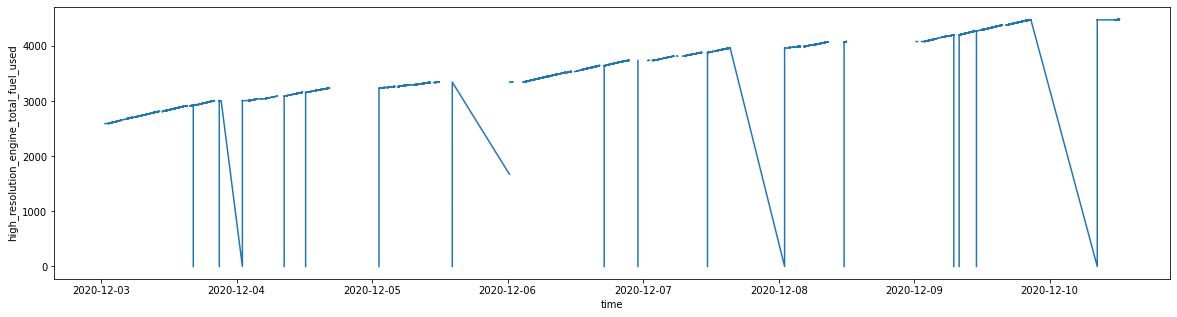

In [11]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x='time', y="high_resolution_engine_total_fuel_used")

In [12]:
df['speed'] = df['speed'].fillna(0)
df['accelerator_pedal_position_1'] = df['accelerator_pedal_position_1'].fillna(0)
df['brake_pedal_position'] = df['brake_pedal_position'].fillna(0)
df['engine_speed'] = df['engine_speed'].fillna(0)
df.loc [(df['engine_speed']==0)&(df['speed'] > 0), 'engine_speed'] = None
df['engine_speed'] = df['engine_speed'].interpolate()

In [13]:
df.loc[df['axle_weight'] < 2.770,  'axle_weight'] = None
df.loc[df['axle_weight'] > MAX_AXLE_WEIGHT*1.5,  'axle_weight'] = None
df['axle_weight'] = df['axle_weight'].interpolate()

In [14]:
def processing_cumulative_values (df: pd.DataFrame, col_name: str)-> pd.DataFrame:
    """
    Обработка кумулятивных значений 
    
    Parameters
    ----------
    df: pandas.DataFrame
        набор данных
        
    col_name: str
        наименование столбца
    

    Returns
    -------
    df: pandas.DataFrame
        набор обработанных данных в pandas.DataFrame
    
    """
    
    
    df['new_col'] = df[col_name].shift() <= df[col_name]
    df.loc[df['new_col'] == False,  col_name] = None
    df[col_name] = df[col_name].interpolate()
    df = df.drop(columns=['new_col'])
    return df

In [15]:
df = processing_cumulative_values(df, 'high_resolution_engine_total_fuel_used')
df = processing_cumulative_values(df, 'high_resolution_total_vehicle_distance')
start_data = df.loc[(df['high_resolution_engine_total_fuel_used'].isna()==False)&\
                    (df['high_resolution_total_vehicle_distance'].isna()==False)].index[0]
df = df.loc[df.index>=start_data]

In [16]:
df['vehicle_distance'] = df['high_resolution_total_vehicle_distance']\
    - df['high_resolution_total_vehicle_distance'].shift()

df.loc[df['speed'] == 0, 'vehicle_distance'] = 0

In [17]:
df['elapsed_time'] = df.index.to_series().diff().dt.seconds.div(1, fill_value=0)

In [18]:
df['fuel_used'] = df['high_resolution_engine_total_fuel_used']\
    - df['high_resolution_engine_total_fuel_used'].shift()
df.loc[df['engine_speed'] == 0, 'fuel_used'] = 0

In [19]:
df['fuel_consumption'] = df['fuel_used']/df['vehicle_distance']*100
df.loc[(df['vehicle_distance'] == 0) | (df['engine_speed'] == 0), 'fuel_consumption'] = 0
df.loc[df['fuel_consumption'] > 500, 'fuel_consumption'] = 500

In [20]:
df['fuel_hour'] = df['fuel_used']*3600/df['elapsed_time']
df['altitude'] = df['altitude'].interpolate()
df['altitude_mean'] = df['altitude'].ewm(span = 550).mean()

In [21]:
df['acceleration'] = df['speed']-df['speed'].shift()

In [22]:
df['slope'] =  df['altitude_mean'] - df['altitude_mean'].shift()

In [23]:
df['change_engine_speed'] = df['engine_speed'] - df['engine_speed'].shift()

In [24]:
def check_data_load(df: pd.DataFrame, data: list)-> list:
    """
    Проверка правильности дат загрузки и разргузки трака
    
    Parameters
    ----------
    df: pandas.DataFrame
        набор данных   
    
    data:  list
        список Timestamp 

    Returns
    -------
    data: list
        проверенные даты (Timestamp)
    """

    
    data_copy = data.copy()
    for i in range(1, len(data_copy)):
        count = df.loc[(df.index>=data_copy[i-1]) & (df.index<=data_copy[i]) & (df['speed'] > 35)].count()[0]
        if count < 5*60/2:
            data.remove(data_copy[i])
    return data

In [25]:
def load_unload_cargo (df: pd.DataFrame):
    """
    Получение дат загрузок и разгрузок
    
    Parameters
    ----------
    df: pandas.DataFrame
        набор данных   

    Returns
    -------
    data_unload: list
        даты разрузок трака
        
    data_load: list
        даты загрузок трака
    
    """
    df['using_axle_weight'] = df['axle_weight'] / MAX_AXLE_WEIGHT
    df['new_col'] = df['using_axle_weight'].shift(-300)/df['using_axle_weight'].shift(300)
    unload_cargo = df.loc[(df['new_col'] < 0.6) & (df['speed'] == 0)]
    load_cargo = df.loc[(df['new_col'] > 1.4) & (df['speed'] == 0)]
    
    # Получаем даты разрузок грузовика
    data_unload = []
    while unload_cargo.shape[0]>0:
        data_unload.append(unload_cargo.index[0])
        unload_cargo = unload_cargo.loc[unload_cargo.index>= (unload_cargo.index[0] + pd.Timedelta(hours=2))]
        
    # Получаем даты загрузок грузовика
    data_load = []
    while load_cargo.shape[0]>0:
        data_load.append(load_cargo.index[0])
        load_cargo = load_cargo.loc[load_cargo.index>= (load_cargo.index[0] + pd.Timedelta(hours=2))]
        
    data_unload = check_data_load(df, data_unload)
    data_load = check_data_load(df, data_load)
    return data_unload, data_load

In [26]:
data_unload, data_load = load_unload_cargo(df)

In [27]:
def get_weight (df: pd.DataFrame)-> pd.DataFrame:
    """
    Получение веса автопоезда за счет соотношение нагрузки на заднюю ось, предпологаем, 
    что груз распологается равномерно в полуприцепе
    
    Parameters
    ----------
    df: pandas.DataFrame
        набор данных   

    Returns
    -------
    df: pandas.DataFrame
        набор данных с добавленым полелем weight_truck приблизительный расчет массы трака с полуприцепом
    """
    data_unload, data_load = load_unload_cargo(df)
    all_data_cargo = data_unload + data_load
    all_data_cargo.extend([df.index[0], df.index[-1]])
    all_data_cargo.sort()
    
    for i in range(1, len(all_data_cargo)):
        df_1 = df.loc[(df.index>=all_data_cargo[i-1]) & (df.index<=all_data_cargo[i])]
        mean_axle_weight = df_1['axle_weight'].mean()
        start_altitude = df_1['altitude'][:30].mean()
        edn_altitude =df_1['altitude'][-30:].mean()
        altitude = (edn_altitude - edn_altitude)/1000 # заность высот в км
        distance = df_1['high_resolution_total_vehicle_distance'][-1] - df_1['high_resolution_total_vehicle_distance'][0]
        #получение нагрузки на заднюю ость на ровной поверхности
        true_axle_weight = mean_axle_weight*abs(1-altitude/distance) # cos() = 1-sin(), sin - отношение противолежащиго катета к гипотенузе
        weight_truck = true_axle_weight/MAX_AXLE_WEIGHT*MAX_WEIGHT_TRUCK
        df.loc[(df.index>=all_data_cargo[i-1]) & (df.index<=all_data_cargo[i]), 'weight_truck'] = weight_truck
        
    df = df.drop(columns=['new_col'])
    return df

In [28]:
df = get_weight(df)

In [29]:
# мощность на преодоление воздушного сопротивления
df['F_air'] = 0.3675*HEIGHT*WIDTH*((df['speed']*0.278)**3)/1000

In [30]:
# мощность затрачиваемая на подем
df['F_climb'] = df['weight_truck'] * 1000* 9.807 *(df['slope']/(df['vehicle_distance']*1000))*(df['speed']*0.278)/1000

In [31]:
# мощность на преодоление качения
df['F_rolling'] =(df['weight_truck'] * 1000* 9.807)*\
                (1+((df['speed']*0.278))/1500)*0.02*\
                (1-df['slope']/(df['vehicle_distance']*1000))*\
                (df['speed']*0.278)/(1000)

In [32]:
df['engine_speed'] = df['engine_speed'].astype(int)

In [33]:
def get_F_engine(x):
    return df_engine[int(x)]*0.95 # потери (КПД)

In [34]:
df['F_engine'] = df['engine_speed'].progress_apply(lambda x: get_F_engine(x))

100%|██████████████████████████████████████████████████████████████████████| 162049/162049 [00:00<00:00, 242226.26it/s]


In [35]:
# мощность затрачиваемая на ускорение
df['F_acceleration'] = (df['weight_truck'] * 1000)*1.1*(df['acceleration']*0.278/df['elapsed_time'])* (df['speed']*0.278)/(1000)

In [36]:
df['F_result'] = df['F_engine']-(df['F_air'] + df['F_climb'] + df['F_rolling']) # мощность на ускорение будет остатком от расчета
df.loc[df['F_result'] < -2000, 'F_result']= -200

In [37]:
df[70000:70010]

,latitude,longitude,altitude,speed,accelerator_pedal_position_1,brake_pedal_position,axle_weight,engine_speed,high_resolution_engine_total_fuel_used,high_resolution_total_vehicle_distance,vehicle_distance,elapsed_time,fuel_used,fuel_consumption,fuel_hour,altitude_mean,acceleration,slope,change_engine_speed,using_axle_weight,weight_truck,F_air,F_climb,F_rolling,F_engine,F_acceleration,F_result
time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-06 03:17:36,55.081418,61.777371,192.0,84.0,0.0,0.0,9.625000,1037,3360.4280,10386.847500,0.050000,2.0,0.0165,33.000000,29.7,202.568568,-1.0,-0.038501,-2.0,0.836957,35.269219,45.108831,-6.219563,164.183458,406.608303,-125.929482,203.535577
2020-12-06 03:17:38,55.081841,61.777395,192.0,84.0,0.0,0.0,9.700000,1037,3360.4450,10386.897500,0.050000,2.0,0.0170,34.000000,30.6,202.530206,0.0,-0.038361,0.0,0.843478,35.269219,45.108831,-6.196988,164.182999,406.608303,0.000000,203.513460
2020-12-06 03:17:40,55.082264,61.777408,191.0,85.0,0.0,0.0,9.500000,1034,3360.4625,10386.945000,0.047500,2.0,0.0175,36.842105,31.5,202.488354,1.0,-0.041852,-3.0,0.826087,35.269219,46.739115,-7.201411,166.186784,405.058335,127.428642,199.333846
2020-12-06 03:17:42,55.082684,61.777409,191.0,84.0,0.0,0.0,9.450000,1035,3360.4810,10386.992500,0.047500,2.0,0.0185,38.947368,33.3,202.446654,-1.0,-0.041700,1.5,0.821739,35.269219,45.108831,-7.090857,164.201155,405.574991,-125.929482,203.355862
2020-12-06 03:17:44,55.083102,61.777402,191.0,84.0,0.0,0.0,9.541667,1036,3360.5010,10387.042500,0.050000,2.0,0.0200,40.000000,36.0,202.405106,0.0,-0.041549,1.0,0.829710,35.269219,45.108831,-6.711863,164.193457,406.091647,0.000000,203.501222
2020-12-06 03:17:46,55.083521,61.777383,191.0,84.0,0.0,0.0,9.633333,1036,3360.5260,10387.101667,0.059167,2.0,0.0250,42.253521,45.0,202.363708,0.0,-0.041398,-0.5,0.837681,35.269219,45.108831,-5.651409,164.171918,406.091647,0.000000,202.462307
2020-12-06 03:17:49,55.084147,61.777336,192.0,84.0,0.0,0.0,9.600000,1037,3360.5515,10387.162500,0.060833,3.0,0.0255,41.917808,30.6,202.326090,0.0,-0.037618,1.5,0.834783,35.269219,45.108831,-4.994684,164.158579,406.608303,0.000000,202.335577
2020-12-06 03:17:51,55.084566,61.777288,192.0,84.0,0.0,0.0,9.575000,1039,3360.5720,10387.212500,0.050000,2.0,0.0205,41.000000,36.9,202.288609,0.0,-0.037481,1.5,0.832609,35.269219,45.108831,-6.054808,164.180111,407.641615,0.000000,204.407481
2020-12-06 03:17:53,55.084984,61.777228,192.0,85.0,0.0,0.0,9.550000,1039,3360.5920,10387.257500,0.045000,2.0,0.0200,44.444444,36.0,202.251263,1.0,-0.037345,0.5,0.830435,35.269219,46.739115,-6.782945,166.178283,407.641615,127.428642,201.507161


<AxesSubplot:xlabel='high_resolution_total_vehicle_distance', ylabel='F_result'>

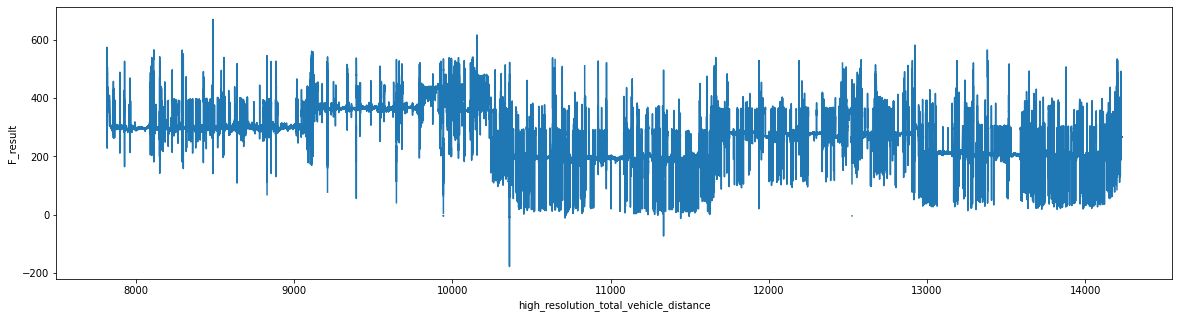

In [38]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x='high_resolution_total_vehicle_distance', y="F_result")


Данный график (баланс мощностей), если он расчитан правельно должен быть равен мощности затрачиваемой на ускорение, в нашем случаее показывает по разбросу: неэфективное использование мощности двигателя

In [39]:
df['F_result'].max(), df['F_result'].min()

(670.4515407358764, -178.38083953944945)

In [40]:
df =  df.loc[(df['F_result'].isna() == False)&(df['speed']>1)]

In [41]:
df['efficient_use'] = (1-abs(df['F_result'])/df['F_engine'])*10
df.loc[df['efficient_use']<1, 'efficient_use'] = 1
df.loc[df['efficient_use']>10, 'efficient_use'] = 10

In [42]:
df['efficient_use'].describe() #В баллах от 1 до 10

count    143827.000000
mean          3.390308
std           1.420796
min           1.000000
25%           2.471114
50%           3.268536
75%           4.564122
max           9.999722
Name: efficient_use, dtype: float64

In [43]:
df[55000:55010]

,latitude,longitude,altitude,speed,accelerator_pedal_position_1,brake_pedal_position,axle_weight,engine_speed,high_resolution_engine_total_fuel_used,high_resolution_total_vehicle_distance,vehicle_distance,elapsed_time,fuel_used,fuel_consumption,fuel_hour,altitude_mean,acceleration,slope,change_engine_speed,using_axle_weight,weight_truck,F_air,F_climb,F_rolling,F_engine,F_acceleration,F_result,efficient_use
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05 08:37:30,55.858781,62.349707,134.0,54.0,13.0,0.0,4.728571,1114,3315.818000,10225.7975,0.0300,2.0,0.006000,20.000000,10.800,130.639108,1.0,0.012244,-5.0,0.411180,16.788119,11.984088,1.008713,49.906176,442.774225,38.534353,379.875248,1.420565
2020-12-05 08:37:33,55.858541,62.349126,134.0,54.0,23.5,0.0,4.742857,1099,3315.822000,10225.8275,0.0300,3.0,0.004000,13.333333,4.800,130.651307,0.0,0.012199,-15.5,0.412422,16.788119,11.984088,1.005052,49.906250,438.640977,0.000000,375.745588,1.433869
2020-12-05 08:37:35,55.858382,62.348732,134.0,54.0,10.0,0.0,4.757143,1113,3315.824000,10225.8575,0.0300,2.0,0.002000,6.666667,3.600,130.663462,0.0,0.012155,14.0,0.413665,16.788119,11.984088,1.001404,49.906323,442.515897,0.000000,379.624082,1.421233
2020-12-05 08:37:37,55.858222,62.348349,133.0,54.0,31.5,0.0,4.771429,1113,3315.829000,10225.8875,0.0300,2.0,0.005000,16.666667,9.000,130.671943,0.0,0.008481,0.5,0.414907,16.788119,11.984088,0.698726,49.912437,442.515897,0.000000,379.920646,1.414531
2020-12-05 08:37:39,55.858063,62.347961,133.0,55.0,34.5,0.0,4.785714,1133,3315.837500,10225.9225,0.0350,2.0,0.008500,24.285714,15.300,130.680393,1.0,0.008450,20.0,0.416149,16.788119,12.662276,0.607785,50.848169,447.682458,39.247952,383.564228,1.432226
2020-12-05 08:37:41,55.857899,62.347563,133.0,56.0,26.0,0.0,4.800000,1162,3315.846000,10225.9525,0.0300,2.0,0.008500,28.333333,15.300,130.688813,1.0,0.008420,28.5,0.417391,16.788119,13.365579,0.719354,51.780148,455.173970,39.961551,389.308889,1.447031
2020-12-05 08:37:43,55.857735,62.347157,133.0,57.0,0.0,0.0,4.850000,1152,3315.848375,10225.9825,0.0300,2.0,0.002375,7.916667,4.275,130.697202,1.0,0.008389,-9.5,0.421739,16.788119,14.094455,0.729542,52.714515,452.590690,40.675150,385.052179,1.492265
2020-12-05 08:37:45,55.857569,62.346746,132.0,56.0,0.0,0.0,4.700000,1124,3315.850750,10226.0250,0.0425,2.0,0.002375,5.588235,4.275,130.701931,-1.0,0.004729,-28.5,0.408696,16.788119,13.365579,0.285192,51.788922,445.357506,-39.961551,379.917812,1.469374
2020-12-05 08:37:47,55.857405,62.346343,132.0,55.0,29.0,0.0,4.750000,1095,3315.853125,10226.0625,0.0375,2.0,0.002375,6.333333,4.275,130.706643,-1.0,0.004712,-28.5,0.413043,16.788119,12.662276,0.316294,50.854058,436.574353,-39.247952,372.741725,1.462125


In [44]:
df = df.reset_index()

In [45]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import time

In [46]:
x_train, x_test = train_test_split(df[label_col+['vehicle_distance', 'acceleration', 'slope']], train_size=0.6, random_state=13)
y_train, y_test = train_test_split(df['efficient_use'], train_size=0.6, random_state=13)

In [47]:
params = {'iterations': 5000,
          'depth':5, 
          'learning_rate':0.05,
          "task_type": "CPU", 
          'loss_function': "RMSE",
          'early_stopping_rounds': 50, 
          'random_seed': 13}

cat_features = []

num_folds = 5

In [48]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    """
    estimators, folds_scores = [], []


    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):


        x_train, x_valid = X.loc[X.index.intersection(train_idx)], X.loc[X.index.intersection(valid_idx)]
        y_train, y_valid = y.loc[y.index.intersection(train_idx)], y.loc[y.index.intersection(valid_idx)]

        model = CatBoostRegressor(**params)
        model.fit(x_train, y_train, cat_features=categorical, verbose=False)
        result = model.predict(x_valid)
        score = r2_score(result, y_valid)
        print(f"Fold {fold+1}, Coefficient of determination = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators

In [49]:
cv = KFold(n_splits=num_folds, random_state=88, shuffle=True)

estimators = catboost_cross_validation(
    params=params, X=x_train, y=y_train, cv=cv, categorical=cat_features
)

Fri Jan 15 12:07:35 2021, Cross-Validation, 86296 rows, 13 cols
Fold 1, Coefficient of determination = 0.99913
Fold 2, Coefficient of determination = 0.99738
Fold 3, Coefficient of determination = 0.99769
Fold 4, Coefficient of determination = 0.99892
Fold 5, Coefficient of determination = 0.99962
Score by each fold: [0.99913, 0.99738, 0.99769, 0.99892, 0.99962]


In [50]:
y_pred = np.zeros(x_test.shape[0])

for estimator in estimators:
    y_pred += estimator.predict(x_test)
y_pred = y_pred / cv.n_splits

In [51]:
print("Coefficient of determination: " + str(r2_score(y_pred, y_test)))

Coefficient of determination: 0.9933206910064665


In [52]:
x_test.head(3)

,latitude,longitude,altitude,speed,accelerator_pedal_position_1,brake_pedal_position,axle_weight,engine_speed,high_resolution_engine_total_fuel_used,high_resolution_total_vehicle_distance,vehicle_distance,acceleration,slope
112888,55.448732,61.934448,198.0,85.0,0.0,0.0,4.552792,1034,4064.2275,12832.6825,0.0625,0.0,0.066164
127324,57.340285,67.172528,50.0,79.0,80.0,0.0,8.433333,1263,4267.7505,13492.3275,0.0450,1.0,-0.017894
90740,60.088901,71.509759,49.0,85.0,0.0,0.0,4.200000,1039,3804.6005,11876.7925,0.0500,0.0,-0.099923


Text(0.5, 1.0, 'Зависимость расхода топлива от скорости')

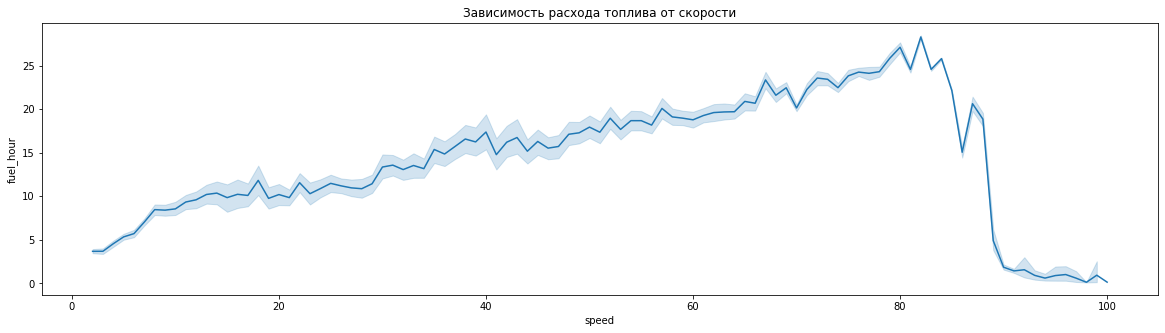

In [53]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x='speed', y="fuel_hour").set_title('Зависимость расхода топлива от скорости')

Text(0.5, 1.0, 'Зависимость расхода топлива от уровня нажатия на педаль газа')

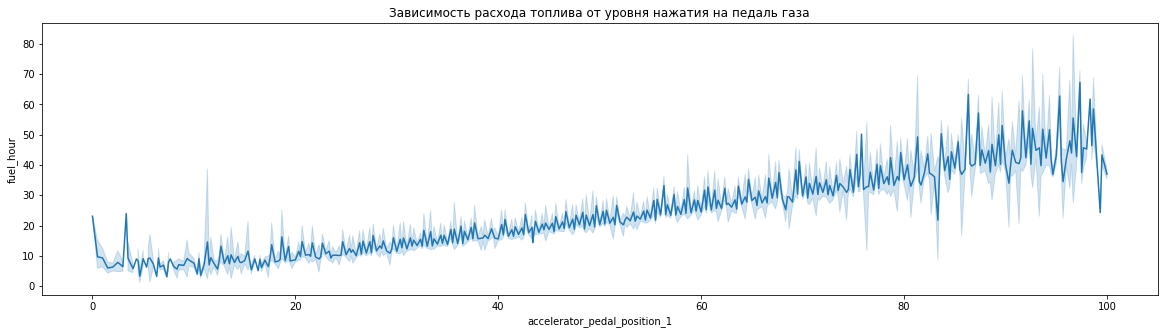

In [54]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x='accelerator_pedal_position_1', y="fuel_hour").set_title('Зависимость расхода топлива от уровня нажатия на педаль газа')

По графикам можно выдвинуть гипотизу что данные не соответствуют автомобилю КАМАЗа 54901